# Modelling
In this part we experiment with differernt models and strive to get the best performing model

## Import the necessary libraries


In [1]:
# Set configuration for notebook
import os

os.chdir("c:\\Users\\Spectra\\flood-prediction")
os.getcwd()

'c:\\Users\\Spectra\\flood-prediction'

In [2]:
# Import libraries
import mlflow
import optuna
import shap
import pandas as pd
import numpy as np
import autogluon as ag
from autogluon.tabular import TabularDataset, TabularPredictor
from src.utils import load_config
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report
from lightgbm import LGBMClassifier

In [3]:
# load config
config = load_config()

## Modelling

**Run automl to get the best model from which we can build upon**

In [18]:
# Load data
train_data = pd.read_csv(config["data"]["train_data_path"])
label = "Flood"


# Split the data into train and validation sets
train, val = train_test_split(
    train_data, test_size=0.1, stratify=train_data[label], random_state=42
)
train = TabularDataset(train)
val = TabularDataset(val)
# Run AutoML with stratified cross-validation
predictor = TabularPredictor(
    label=label,
    eval_metric="f1",
    sample_weight="auto_weight",
).fit(train_data, presets=["medium_quality", "optimize_for_deployment"])

# Get the leaderboard of models
predictor.leaderboard(val)

No path specified. Models will be saved in: "AutogluonModels\ag-20240531_100432"
Presets specified: ['medium_quality', 'optimize_for_deployment']
Beginning AutoGluon training ...
AutoGluon will save models to "AutogluonModels\ag-20240531_100432"
=================== System Info ===================
AutoGluon Version:  1.1.0
Python Version:     3.11.5
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.22631
CPU Count:          8
Memory Avail:       0.66 GB / 15.85 GB (4.2%)
Disk Space Avail:   76.81 GB / 475.53 GB (16.2%)
Train Data Rows:    16435
Train Data Columns: 8
Label Column:       Flood
AutoGluon infers your prediction problem is: 'binary' (because only two unique label-values observed).
	2 unique label values:  [1, 0]
	If 'binary' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Problem Type:       binary
Preprocessi

,model,score_test,score_val,eval_metric,pred_time_test,pred_time_val,fit_time,pred_time_test_marginal,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,ExtraTreesEntr,0.998487,0.935143,f1,0.879802,0.685604,6.042871,0.879802,0.685604,6.042871,1,True,3
1,ExtraTreesGini,0.998487,0.932127,f1,0.932001,0.462635,6.686260,0.932001,0.462635,6.686260,1,True,2
2,RandomForestGini,0.998487,0.936556,f1,1.014883,1.332486,8.426958,1.014883,1.332486,8.426958,1,True,1
3,WeightedEnsemble_L2,0.978659,0.948640,f1,3.802589,4.198123,448.612720,0.014820,0.015901,4.049283,2,True,6
4,LightGBMLarge,0.977238,0.940998,f1,0.046808,0.038088,23.140513,0.046808,0.038088,23.140513,1,True,5
5,NeuralNetFastAI,0.940276,0.933535,f1,0.914275,1.663408,400.266835,0.914275,1.663408,400.266835,1,True,4


**Validate Model on test data**

In [5]:
model_path = os.path.normpath(config["modelling"]["models_directory"])
predictor = TabularPredictor.load(model_path)

In [6]:
# Load test data

test_data = pd.read_csv(config["data"]["test_data_path"]).drop("Flood", axis=1)
y_true = pd.read_csv(config["data"]["test_data_path"])["Flood"].values
test = TabularDataset(config["data"]["test_data_path"])
test_no_label = TabularDataset(test_data)

Loaded data from: data/testing_data/test.csv | Columns = 9 / 9 | Rows = 4109 -> 4109


In [7]:
predictions = predictor.predict(test_no_label)

In [8]:
perf = predictor.evaluate(test, auxiliary_metrics=False)
perf

{'f1': 0.9398907103825137}

In [9]:
print(classification_report(y_true, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3283
           1       0.94      0.94      0.94       826

    accuracy                           0.98      4109
   macro avg       0.96      0.96      0.96      4109
weighted avg       0.98      0.98      0.98      4109



The best model is saved in the folder models.

c:\Users\Spectra\flood-prediction\.venv\Lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


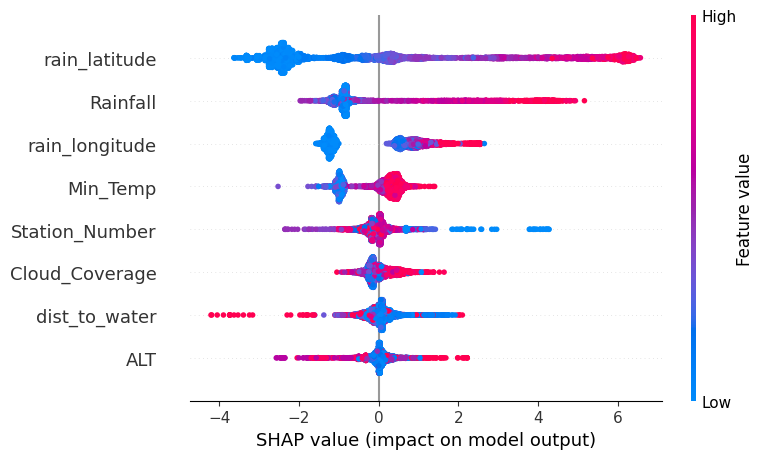

In [16]:
# Load the best model
best_model = predictor._trainer.load_model("LightGBM")
lgbm_model = best_model.model
# Initialize SHAP explainer with the LightGBM model
explainer = shap.TreeExplainer(lgbm_model)

# Generate SHAP values
shap_values = explainer.shap_values(test_data)
# Summary plot
shap.summary_plot(shap_values, test_data)